# Problem Set 1 Question 1b

We extract out the utilities provided from the problem set here

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)


In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')


Let's visualise the data we are working with for logistic regression

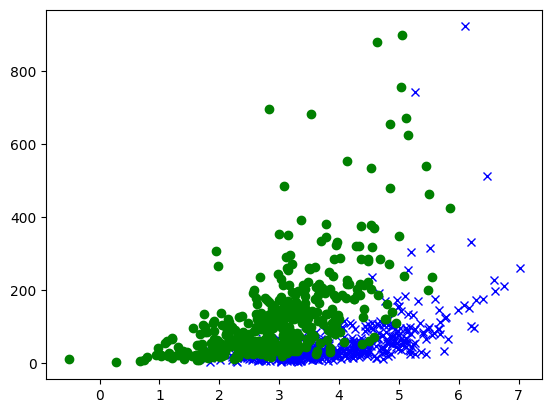

In [11]:
x_train, y_train = load_dataset("_data/ds1_train.csv", add_intercept=True)
plt.figure()
plt.plot(x_train[y_train == 1, -2], x_train[y_train == 1, -1], 'bx', linewidth=2)
plt.plot(x_train[y_train == 0, -2], x_train[y_train == 0, -1], 'go', linewidth=2)

# Coding the Main `LogisticRegression` Model

Goal: We want to use Newton's method to train a Logistic Regression Model to predict given some data. We need to implement the following methods:
1. `fit(x, y)`: Train the model given training data `x` and labelled outputs `y`
2. `predict(x)`: Given inputs `x`, predict `y`

## Newton's Method

Recall that for Newton's method, we should use the following:

$$
\theta^{(i + 1)} \coloneqq \theta^{(i)} + H^{-1} \nabla_\theta \mathcal{l}(\theta)
$$
- $l$ is our likelihood that we are trying to maximise
- $H$ is our Hessian

We saw in part 1(a) that:

$$
\begin{align*}
h_\theta(x^{(i)}) &= \frac{1}{1 + \exp(-\theta^T x^{(i)})}\\
J(\theta) &= -\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \\
\nabla_\theta J(\theta) &= -\frac{1}{m} \sum_{i = 1}^{m} (y^{(i)} - h_\theta(x^{(i)})) x^{(i)} \\
\nabla_\theta^2 J(\theta) &= \frac{1}{m} \sum_{i = 1}^{m} h_\theta(x^{(i)})(1 - h_\theta(x^{(i)})) x^{(i)} (x^{(i)})^T
\end{align*}
$$

However, now we would like to work with a design matrix $X = \begin{bmatrix} (x^{(1)})^T \\ \vdots \\ (x^{(m)})^T \end{bmatrix} \in \mathbb{R}^{m \times d}$ and $y \in \mathbb{R}^m$. These formulas are now rewritten as:

$$
h = h_\theta(X) = \sigma(X \theta) = \frac{1}{1 + \exp(-X \theta)} \in \mathbb{R}^m
$$
- $\theta^T x$ is now $X \theta$.
- $\frac{1}{1 + \exp(-X \theta)} \in \mathbb{R}^m$ is an element-wise operation now, giving 1 row per entry in $X$.

$$
J(\theta) = -\frac{1}{m} (y^T \log h + (1 - y)^T \log(1 - h)) \in \mathbb{R}
$$
- $y^T \log(h)$ sums over all examples automatically.

$$
\nabla_\theta J(\theta) = \frac{1}{m} X^T (h - y) \in \mathbb{R}^d
$$
- Each column of $X^T$ corresponds to a feature.
- $h - y \in \mathbb{R}^m$ is the vector of errors for all samples.
- Multiplying $X^T$ by $h - y$ sums the contributions of each feature across all examples.

$$
\nabla_\theta^2 J(\theta) = \frac{1}{m} X^T \text{diag}(h \odot (1 - h)) X \in \mathbb{R}^{d \times d}
$$
- We define the diagonal matrix of variances $\text{diag}(h \odot (1 - h))$, where $h \odot (1 - h)$ is element-wise multiplication (Hadamard product).


In [15]:
def main(train_path, eval_path, pred_path):
    """Problem 1(b): Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    x_train, y_train = load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***
    model = LogisticRegression() # Create the LogisticRegression instance
    model.fit(x_train, y_train) # Fit the model to the training data

    plot(x_train, y_train, model.theta)

    x_test, y_test = load_dataset(eval_path, add_intercept=True) # Load evaluation dataset
    plot(x_test, y_test, model.theta)
    predictions = model.predict(x_test) # Make predictions on the evaluation dataset
    predictions = [0 if i < 0.5 else 1 for i in predictions]

    correct = 0
    wrong = 0
    for i in range(len(y_test)):
        if y_test[i] == predictions[i]:
            correct += 1
        else:
            wrong += 1

    print(f"Correct: {correct}, wrong: {wrong}")

    np.savetxt(pred_path, predictions, delimiter=',', fmt="%d") # Save predictions
    # *** END CODE HERE ***


class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])

        num_iterations = 0
        while True:
            num_iterations += 1
            if num_iterations >= self.max_iter:
                break

            predictions = self.predict(x)
            # J'(Theta) = 1/m X^T . (h - y)
            first_derivative = 1 / x.shape[0] * x.T.dot(predictions - y)
            # J''(Theta) = 1 / m X^T R X, R = diag(h * (1 - h)) (Hadamard product between h and (1 - h))
            second_derivative = 1 / x.shape[0] * (predictions * (1 - predictions) * x.T).dot(x)

            updated_theta = self.theta - np.linalg.inv(second_derivative).dot(first_derivative)
            if np.linalg.norm(self.theta - updated_theta, ord=1) < self.eps: # Check L1 norm
                break

            self.theta = updated_theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])

        # h(x) = 1/(1 + exp(- X Theta ))
        return 1 / (1 + np.exp(-x.dot(self.theta)))
        # *** END CODE HERE ***

Correct: 90, wrong: 10


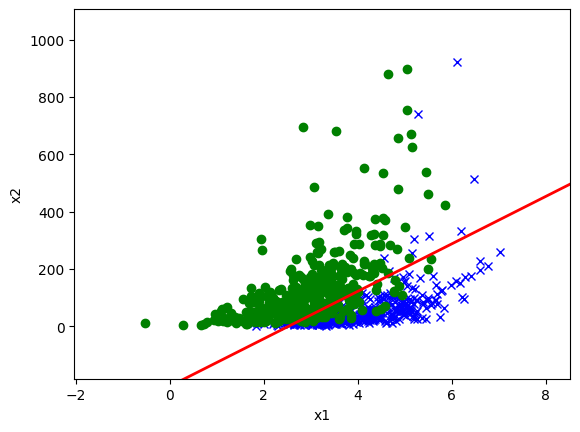

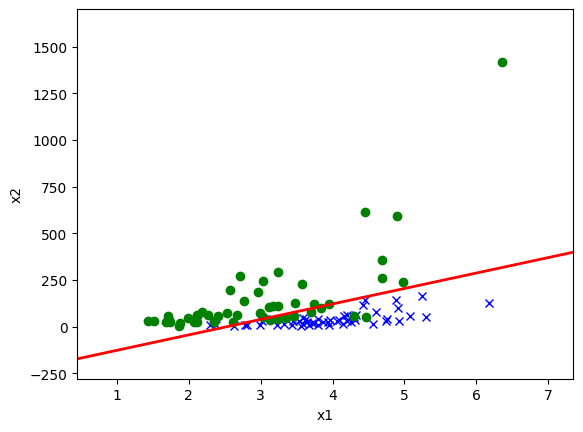

In [16]:
main("_data/ds1_train.csv", "_data/ds1_valid.csv", "_data/ds1_pred.csv")